# Dependencias

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
from tensorflow import keras
from keras.models import Sequential
from keras.layers.core import Dense
from keras.models import model_from_json
import pickle 
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import tensorflow as tf
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7



# Entrenamiento

## Parámetros

In [ ]:
gb_x = 51 
gb_y = 51 
gb_s = 0

PATH = "/content/drive/MyDrive/Aux/FinalSargazo/"

## Funciones para generar los datos de prueba

In [ ]:
def etiquetar(lista_muestras, etiqueta):
  '''Etiqueta un conjunto de muestras'''
  return [(x, etiqueta) for x in lista_muestras]

In [ ]:
def sacar_pruebas(url):
  print("Leyendo Imagen",url.split("/")[-1])
  # cargamos la imagen real
  img_a = cv2.imread(url)
  img = cv2.cvtColor(img_a, cv2.COLOR_BGR2RGB)
  del img_a
  # cargamos la mascara sargazo 
  sar_url = url.split(".")[0]+"S.png"
  sar_a = cv2.imread(sar_url)
  sar = cv2.cvtColor(sar_a, cv2.COLOR_BGR2RGB)
  del sar_a
  # Creamos la máscara no sargazo
  no_sar = img * (sar == 0)

  del img
  # Aplicamos blur 
  #sar =  aplicar_blur(sar, gb_x, gb_y, gb_s)
  #no_sar =  aplicar_blur(no_sar, gb_x, gb_y, gb_s)

  # Redimensionamos la imagen a una lista de pixeles
  re_sar = sar.reshape((-1,3))
  re_no_sar = no_sar.reshape((-1,3))
  del sar
  del no_sar
  # Se generan las pruebas
  lista_sar = re_sar[np.sum(re_sar, axis=1) != 0,:]
  lista_no_sar = re_no_sar[np.sum(re_no_sar, axis=1) != 0,:]
  del re_sar 
  del re_no_sar
  # etiquetamos los vectores
  lista_etiquetada = etiquetar(lista_sar, 1)
  lista_etiquetada = lista_etiquetada + etiquetar(lista_no_sar[:lista_sar.shape[0]*2], 0)
  del lista_sar 
  del lista_no_sar
  return lista_etiquetada

In [ ]:
def aplicar_blur(img, gb_x, gb_y=None, gb_s=0):
  if gb_x%2 != 1:
    gb_x += 1
  if gb_y is None:
    gb_y = gb_x
  elif gb_y%2 != 1:
    gb_y += 1

  return cv2.GaussianBlur(img,(gb_x,gb_y),gb_s)

## Generar datos de prueba

### Generación de datos de prueba

In [ ]:
imagenes = list()
for imagen in os.listdir(PATH):
  if (not imagen.endswith("S.png")) and (not imagen.endswith("pickle")) \
      and (not imagen.endswith("json")) and (not imagen.endswith("h5")):
    imagenes.append(PATH+imagen)

In [ ]:
imagenes

['/content/drive/MyDrive/Aux/FinalSargazo/S1.png',
 '/content/drive/MyDrive/Aux/FinalSargazo/S2.png',
 '/content/drive/MyDrive/Aux/FinalSargazo/S3.png',
 '/content/drive/MyDrive/Aux/FinalSargazo/S4.png',
 '/content/drive/MyDrive/Aux/FinalSargazo/S5.png',
 '/content/drive/MyDrive/Aux/FinalSargazo/S6.png',
 '/content/drive/MyDrive/Aux/FinalSargazo/S7.png',
 '/content/drive/MyDrive/Aux/FinalSargazo/S8.png',
 '/content/drive/MyDrive/Aux/FinalSargazo/S9.png',
 '/content/drive/MyDrive/Aux/FinalSargazo/S10.png',
 '/content/drive/MyDrive/Aux/FinalSargazo/S11.png',
 '/content/drive/MyDrive/Aux/FinalSargazo/S12.png',
 '/content/drive/MyDrive/Aux/FinalSargazo/S13.png',
 '/content/drive/MyDrive/Aux/FinalSargazo/S14.png',
 '/content/drive/MyDrive/Aux/FinalSargazo/S15.png',
 '/content/drive/MyDrive/Aux/FinalSargazo/S16.png',
 '/content/drive/MyDrive/Aux/FinalSargazo/S17.png',
 '/content/drive/MyDrive/Aux/FinalSargazo/S18.png',
 '/content/drive/MyDrive/Aux/FinalSargazo/S19.png',
 '/content/drive/MyDr

In [ ]:
train_set = [sacar_pruebas(url) for url in imagenes]

Leyendo Imagen S1.png
Leyendo Imagen S2.png
Leyendo Imagen S3.png
Leyendo Imagen S4.png
Leyendo Imagen S5.png
Leyendo Imagen S6.png
Leyendo Imagen S7.png
Leyendo Imagen S8.png
Leyendo Imagen S9.png
Leyendo Imagen S10.png
Leyendo Imagen S11.png
Leyendo Imagen S12.png
Leyendo Imagen S13.png
Leyendo Imagen S14.png
Leyendo Imagen S15.png
Leyendo Imagen S16.png
Leyendo Imagen S17.png
Leyendo Imagen S18.png
Leyendo Imagen S19.png
Leyendo Imagen S20.png
Leyendo Imagen S21.png
Leyendo Imagen S22.png
Leyendo Imagen S23.png
Leyendo Imagen S24.png
Leyendo Imagen S25.png
Leyendo Imagen S26.png


### Generación de X, Y

In [ ]:
# encadenamos las pruebas para hacer solo una lista full
train_set_new = list()
for lista in train_set:
  train_set_new.extend(lista)
train_set = train_set_new

In [ ]:
np.random.shuffle(train_set)

In [ ]:
X = np.array([x[0] for x in train_set])
Y = np.array([x[1] for x in train_set])
del train_set

In [ ]:
def guardar(nombre,datos):
  with open(nombre+'.pickle', 'wb') as f:
    pickle.dump(datos, f)

In [ ]:
guardar(PATH+"X_dos_clases_nn_especial",X)
guardar(PATH+"Y_dos_clases_nn_especial",Y)

## Entrenamiento de los modelos

In [ ]:
def cargar(nombre):
  with open(nombre+'.pickle', 'rb') as f:
    entry = pickle.load(f)
  
  return entry

X = cargar(PATH+"X_dos_clases_nn_especial")
Y = cargar(PATH+"Y_dos_clases_nn_especial")

### Modelo

In [ ]:
model = Sequential()
model.add(Dense(20, input_dim=3, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# cambiar a capas con 2^n neuronas, hace mejores las cosas

optimizador = keras.optimizers.Adam(learning_rate=0.002, beta_1=0.9) #beta_2 = 0.999
model.compile(loss='binary_crossentropy',
              optimizer=optimizador,
              metrics=['binary_accuracy'])

In [ ]:
lote = 1_000
for i in range(100):
  print("Epoca "+str(i+1))
  for i in range(X.shape[0]//lote):
    batch = X[i*lote:(i+1)*lote,:]
    real = Y[i*lote:(i+1)*lote]
    loss = model.train_on_batch(batch, real)
  print("\tPerdida", loss[0])
  # serializar el modelo a JSON
  if (i+1)%20==0:
    model_json = model.to_json()
    with open(PATH+"NN.json", "w") as json_file:
        json_file.write(model_json)
    # serializar los pesos a HDF5
    model.save_weights(PATH+"NN.h5")
  
# evaluamos el modelo
#scores = model.evaluate(X, Y)

#print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Epoca 1
	Perdida 0.02078928053379059
Epoca 2
	Perdida 0.016026349738240242
Epoca 3
	Perdida 0.008190225809812546
Epoca 4
	Perdida 0.007807076442986727
Epoca 5
	Perdida 0.008178035728633404
Epoca 6
	Perdida 0.007551718037575483
Epoca 7
	Perdida 0.007476501166820526
Epoca 8
	Perdida 0.006357122212648392
Epoca 9
	Perdida 0.0054708318784832954
Epoca 10
	Perdida 0.005460701417177916
Epoca 11
	Perdida 0.0054070474579930305
Epoca 12
	Perdida 0.004896165337413549
Epoca 13
	Perdida 0.0046002548187971115
Epoca 14
	Perdida 0.004757623188197613
Epoca 15
	Perdida 0.00501820957288146
Epoca 16
	Perdida 0.005055277608335018
Epoca 17
	Perdida 0.005055122077465057
Epoca 18
	Perdida 0.004621682222932577
Epoca 19
	Perdida 0.004639043472707272
Epoca 20
	Perdida 0.005018536001443863
Epoca 21
	Perdida 0.004862783011049032
Epoca 22
	Perdida 0.005143408663570881
Epoca 23
	Perdida 0.004978018347173929
Epoca 24
	Perdida 0.005489502102136612
Epoca 25
	Perdida 0.005716298241168261
Epoca 26
	Perdida 0.0051696430891

In [ ]:
scores = model.evaluate(X, Y)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

16141/16141 [==============================] - 53s 3ms/step - loss: 0.0025 - binary_accuracy: 0.9994

binary_accuracy: 99.94%


In [ ]:
PATH = "/content/drive/MyDrive/Aux/Mascaras/"
# cargar json y crear el modelo
json_file = open(PATH+"NN.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# cargar pesos al nuevo modelo
model.load_weights(PATH+"NN.h5")
print("Cargado modelo desde disco.")
 
# Compilar modelo cargado y listo para usar.
optimizador = keras.optimizers.Adam(learning_rate=0.002, beta_1=0.9) #beta_2 = 0.999
model.compile(loss='binary_crossentropy', optimizer=optimizador, metrics=['binary_accuracy'])

Cargado modelo desde disco.


# Resultados

## Función para hacer las pruebas

In [ ]:
def generar_prediccion(imagen, clasificador):
  '''Genera la imagen predicha

  Parámetros
  imagen: Matriz de la imágen
  clasificador: clasificador 
  '''

  re_img = imagen.reshape((-1,3))

  prediccion = clasificador.predict(re_img)

  prediccion = prediccion.reshape((imagen.shape[0],imagen.shape[1]))

  return prediccion > 0.5

In [ ]:
def prediccion(imagen, model):
  res = generar_prediccion(imagen, clasificador=model)
  figure, axis = plt.subplots(1,3, figsize=(20,40))
  pixeles_sargazo = np.sum(res)
  print("INFORMACIÓN:")
  print("PIXELES CLASIFICADOS COMO SARGAZO:",pixeles_sargazo)
  print("PORCENTAGE DE SARGAZO:",round( (pixeles_sargazo/(imagen.shape[0]*imagen.shape[1]))*100 ,2),"%")
  axis[0].imshow(imagen)
  axis[0].set_title("Original")
  axis[1].imshow(res, cmap="gray")
  axis[1].set_title("Resultado")
  axis[2].imshow(imagen * res.reshape( (res.shape[0],res.shape[1],1) ))
  axis[2].set_title("Enmascarado")
  for i in range(3):
    axis[i].set_yticklabels([])
    axis[i].set_xticklabels([])
  plt.show()

## Resultados

In [ ]:
imagen = cv2.imread("/content/drive/MyDrive/Aux/Mascaras/18.png")
imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
imagen2 = cv2.imread("/content/drive/MyDrive/Aux/Mascaras/15.png")
imagen2 = cv2.cvtColor(imagen2, cv2.COLOR_BGR2RGB)

### Imagen 1

INFORMACIÓN:
PIXELES CLASIFICADOS COMO SARGAZO: 105042
PORCENTAGE DE SARGAZO: 8.55 %


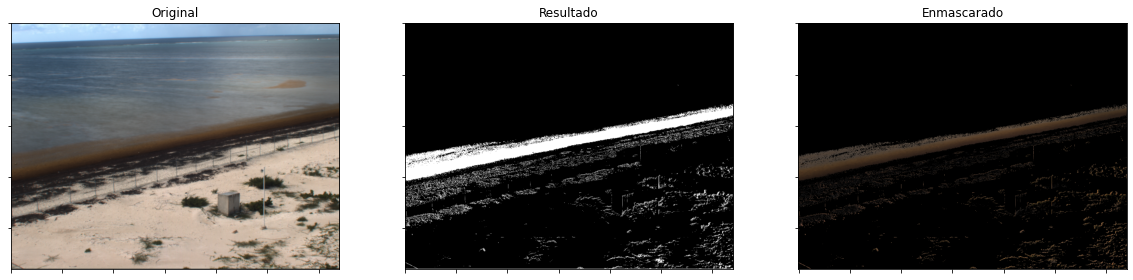

In [ ]:
prediccion(imagen, model)

### Imagen 2

INFORMACIÓN:
PIXELES CLASIFICADOS COMO SARGAZO: 119429
PORCENTAGE DE SARGAZO: 9.72 %


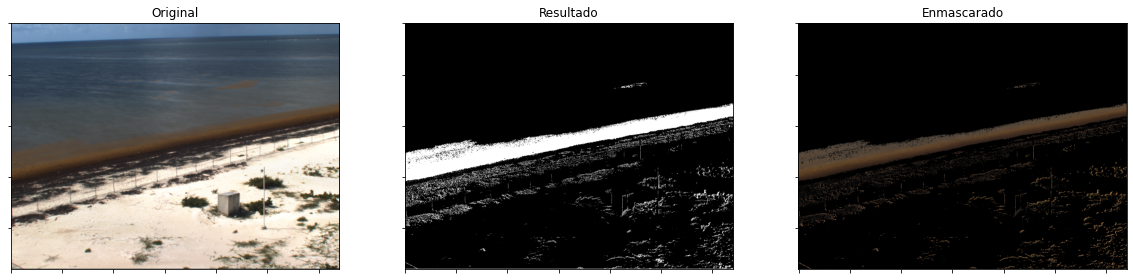

In [ ]:
prediccion(imagen2, model)

### Imagen 3

INFORMACIÓN:
PIXELES CLASIFICADOS COMO SARGAZO: 119429
PORCENTAGE DE SARGAZO: 9.72 %


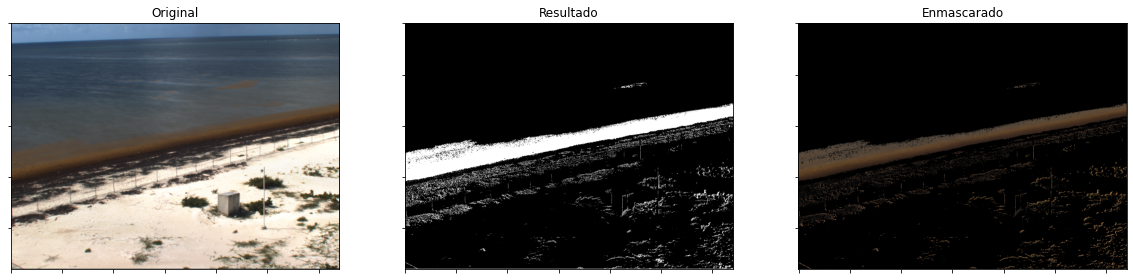

In [ ]:
imagen = cv2.imread("/content/drive/MyDrive/Aux/Mascaras/17.png")
imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
prediccion(imagen2, model)

### Imagen de prueba

In [ ]:
imagen_prueba = cv2.imread("/content/drive/MyDrive/Aux/Mascaras/prueba1.png")
imagen_prueba = cv2.cvtColor( imagen_prueba, cv2.COLOR_BGR2RGB)

INFORMACIÓN:
PIXELES CLASIFICADOS COMO SARGAZO: 70951
PORCENTAGE DE SARGAZO: 5.77 %


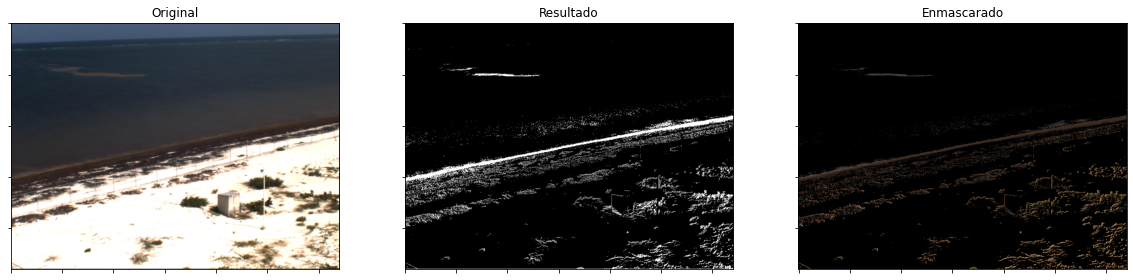

In [ ]:
prediccion(imagen_prueba, model)